{'epoch': 10, 'train_auc': 0.6890240560991914, 'val_auc': 0.6876221862538593}
{'epoch': 20, 'train_auc': 0.6906825378883971, 'val_auc': 0.6894832598913301}
{'epoch': 30, 'train_auc': 0.6936672061619087, 'val_auc': 0.6930791091016655}
{'epoch': 40, 'train_auc': 0.6913650786015225, 'val_auc': 0.6891752669335156}
EarlyStopping!!!
['train_auc', 'val_auc']


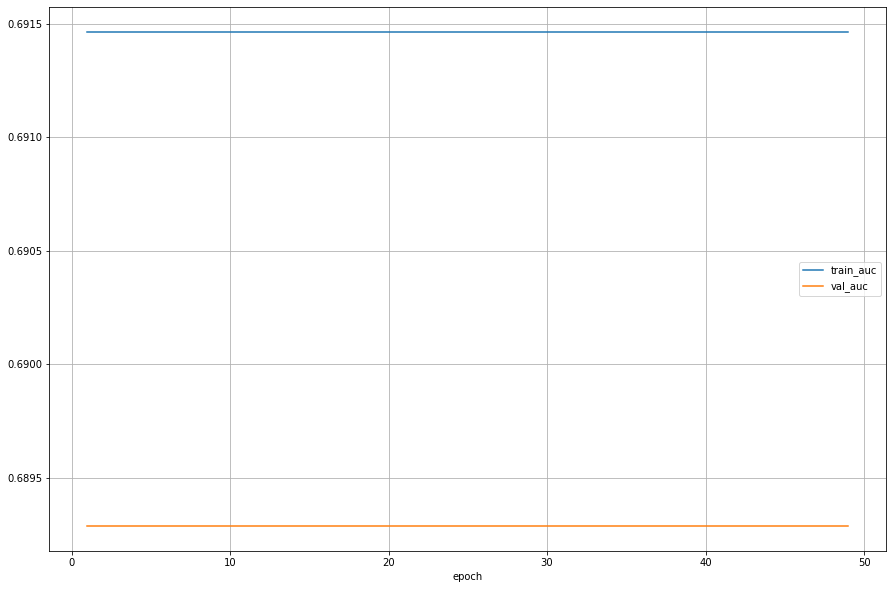

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import defaultdict
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score
import warnings
import os
warnings.filterwarnings('ignore') # 关闭警告

def create_dataloader(X, y, batch_size=1, shuffle=True): # 创建batch迭代器函数
    torch_dataset = TensorDataset(X, y)
    loader = DataLoader(dataset=torch_dataset, batch_size=batch_size, shuffle=shuffle)
    return loader


def get_loss(task): # 获取损失函数
    if task == "binary":
        criterion = torch.nn.BCELoss() # 注：此损失函数要求：1.每个样本只能有一个概率值，即输出是1 dim的tensor；2.要求标签是float类型
    elif task == "multiclass":
        criterion = torch.nn.CrossEntropyLoss() # 注：此损失函数要求：1.每个样本必须有每个类别的概率，即便是2分类，即输出是2 dim的tensor；2.要求标签是long类型
    elif task == "regression_1":
        criterion = torch.nn.L1Loss()
    elif task == "regression_2":
        criterion = torch.nn.MSELoss()
    else:
        raise ValueError("Please input correct value!!!")
    return criterion


def get_optimizer(params, opt_criterion, learning_rate, l2): # 获取梯度优化器函数
    if learning_rate <= 0 or l2 < 0: 
        raise ValueError("Please input correct learning_rate and l2!!!")
    if opt_criterion.lower() == "adam":
        optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=l2)
    elif opt_criterion.lower() == "adagrad":
        optimizer = torch.optim.Adagrad(params, lr=learning_rate, weight_decay=l2)
    elif opt_criterion.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(params, lr=learning_rate, weight_decay=l2)
    elif opt_criterion.lower() == "sgd":
        optimizer = torch.optim.SGD(params, lr=learning_rate, weight_decay=l2)
    else:
        raise ValueError("Please input correct opt_criterion!!!")
    return optimizer

def weight_init(m): # 网络参数初始化函数
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
        

def seed_torch(seed=2022): # 固定所有随机种子函数
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    

# 预测/验证函数
def predict_model(model, test_X, test_y = None, batch_size=1, task=None, metrics=None, device="cpu"): # 有test_y时验证，没有时预测
    test_loader = create_dataloader(test_X, test_y, batch_size=batch_size, shuffle=False)
    loss_func = get_loss(task)
    model = model.eval()
    pred_ans, loss = [], 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device).float()
            target = target.to(device).float().squeeze()
            output = model(data).squeeze(dim=-1)
            pred_ans.append(output.cpu().data.numpy())
            loss += loss_func(output, target).item()
    y_pred = np.concatenate(pred_ans).astype("float64")
    
    if test_y is not None:
        metrics_d = {}
        for i in metrics:
            if "auc" in i:
                metrics_d["auc"] = roc_auc_score(test_y.squeeze().data.numpy(), y_pred) # roc_auc_score的真实标签必须在前面
            elif "loss" in i:
                metrics_d["loss"] = loss/len(y_pred)
        return metrics_d
    else:
        return y_pred


def train_model(model, X, y, valid_data=None, valid_split=0., batch_size=1, opt_criterion="adam", task="binary", \
                metrics=["loss","auc"], eval_metric="auc", epochs=100, early_stopping_bounds=None, seed=2022, \
                learning_rate=0.01, l2=0.01, shuffle=True, save_path=None, device="cpu", verbose=0, is_plt=True):
    
    # 固定随机数种子
    seed_torch(seed=seed)
    
    # 模型设置
    model = model.to(device) # 将参数部署到指定设备
    model.apply(weight_init) # 初始化参数
    loss_func = get_loss(task) # 获取损失函数
    optimizer = get_optimizer(model.parameters(), opt_criterion, learning_rate, l2) # 获取梯度优化器
    
    # 数据设置
    X, y = torch.tensor(X), torch.tensor(y).unsqueeze(dim=1) # 将numpy的输入转为tensor，记得要将标签升维用以切分数据集，后面再降为1dim
    if valid_data and len(valid_data) == 2: # 优先自主设置验证集
        train_loader = create_dataloader(X, y, batch_size=batch_size, shuffle=shuffle)
        val_X, val_y = valid_data[0], valid_data[1]
        valid_loader = create_dataloader(val_X, val_y, batch_size=batch_size, shuffle=shuffle)
    elif 1 > valid_split > 0: # 从数据中拆分验证集
        len_data = list(range(X.shape[0]))
        np.random.shuffle(len_data)
        train_index, valid_index = len_data[:int((1-valid_split)*X.shape[0])], len_data[int((1-valid_split)*X.shape[0]):] # 获取训练集和验证集各自索引列表
        X, val_X, y, val_y = X[train_index], X[valid_index], y[train_index], y[valid_index]
        train_loader = create_dataloader(X, y, batch_size=batch_size, shuffle=shuffle)
        valid_loader = create_dataloader(val_X, val_y, batch_size=batch_size, shuffle=shuffle)
    elif valid_split == 0: # 如果不设置验证集
        train_loader = create_dataloader(X, y, batch_size=batch_size, shuffle=shuffle)
        valid_loader = None
    else:
        raise ValueError("Please input correct valid_dataset!!!")

    # 训练模型
    metrics_total = [] # 所有迭代次数指标结果集合
    metrics_dict = {} # 每个epoch指标结果
    if eval_metric or save_path: # 如果使用早停或者要保存参数
        if eval_metric not in ["auc", "loss", None]:
                raise ValueError("Please input correct eval_metric!!!!")
        threshold = float("inf") # 早停阈值（实时更新）
        cnt = 0 # 早停计数器
    
    for epoch in range(1, epochs+1):
        metrics_dict["epoch"] = epoch
        
        # 训练
        model = model.train()
        for data, target in train_loader:
            data = data.to(device).float()
            target = target.to(device).float().squeeze() # 标签后面做运算时候必须是1dim
            output = model(data).squeeze(dim=-1) # 如果是二分类或回归，输出必须是1dim，如果是多分类，dim=-1不会改变输出
            loss = loss_func(output, target)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10, norm_type=2) # 梯度裁剪，参数介绍：参数集合；最大梯度范数；梯度范数类型
            optimizer.step()
            
        # 训练集指标获取
        metric_train_dict = predict_model(model, X, y, batch_size=batch_size, task=task, metrics=metrics, device=device)
        for i in metric_train_dict: metrics_dict["train_"+i] = metric_train_dict[i]
        if not valid_loader: 
            if verbose > 0 and epoch % verbose == 0: print(metrics_dict) # 如果不需要验证直接输出指标结果
            metrics_total.append(metrics_dict) # 记录指标结果
        
        # 验证
        if valid_loader: # 如果需要验证
            # 验证集指标获取
            metric_val_dict = predict_model(model, val_X, val_y, batch_size=batch_size, task=task, metrics=metrics, device=device)
            for i in metric_val_dict: metrics_dict["val_"+i] = metric_val_dict[i]
            if verbose > 0 and epoch % verbose == 0: print(metrics_dict)
            metrics_total.append(metrics_dict) # 记录指标结果
            
            if eval_metric or save_path:        
                val_metric = metrics_dict["val_"+eval_metric] if eval_metric == "loss" else -metrics_dict["val_"+eval_metric]
                if val_metric < threshold:
                    threshold, cnt = val_metric, 0
                    if save_path:
                        torch.save(model.state_dict(), save_path) # 载入模型参数时：model = Network().load_state_dict(torch.load(path)), Network是该自定义的网络
                        print("model is saved")
                elif val_metric >= threshold and eval_metric:
                    cnt += 1
                    if cnt > early_stopping_bounds: 
                        print("EarlyStopping!!!")
                        break
    
        
    # 指标可视化
    if is_plt:
        metrics_total_dict = defaultdict(list)
        for m_dict in metrics_total:
            for key in m_dict:
                if key != "epoch": metrics_total_dict[key].append(m_dict[key])
        metrics_total_list = list(metrics_total_dict.values())
        metrics_total_names = list(metrics_total_dict.keys())
        fig, ax = plt.subplots(len(metrics_total_list)//2, figsize=(15,10))
        if not isinstance(ax, np.ndarray): ax = [ax]
        for i in range(len(ax)):
            train_data, valid_data = metrics_total_list[i], metrics_total_list[i+2 if len(ax) == 2 else -1]
            train_name, valid_name = metrics_total_names[i], metrics_total_names[i+2 if len(ax) == 2 else -1]
            ax[i].plot(range(1, len(train_data)+1), train_data, label=train_name)
            ax[i].plot(range(1, len(valid_data)+1), valid_data, label=valid_name)
            ax[i].set_xlabel('epoch')
            ax[i].grid(True)
            ax[i].legend()

    return model

if __name__ == "__main__":
    # 获取数据
    df = pd.read_csv("./dataset/binary_practice_data.csv")
    X, y = df.iloc[:,:-1], df.iloc[:,-1]
    fea_names = list(X.columns)
    X_np, y_np = np.array(X), np.array(y)
    X_tensor, y_tensor = torch.tensor(np.array(X)).float(), torch.tensor(np.array(y)).float().unsqueeze(dim=1)
    
    # 定义网络
    class Net(nn.Module): # 定义网络结构
        def __init__(self, dim=10):
            super(Net, self).__init__()
            self.f = nn.Sequential(nn.Linear(dim, dim), nn.Linear(dim, dim), nn.Linear(dim, dim//2), \
                                   nn.Linear(dim//2, dim//2//2), nn.Linear(dim//2//2, 1))
            self.dropout = nn.Dropout(0.2)
        def forward(self, x):
            return F.sigmoid(self.dropout(self.f(x)))
    # 开始训练
    model = Net(dim=49) 
    model1 = train_model(model, X_np, y_np, valid_data=None, valid_split=0.2, batch_size=128, opt_criterion="adam", task="binary", \
                metrics=["auc"], eval_metric="auc", epochs=100, early_stopping_bounds=10, seed=2022, \
                learning_rate=0.01, l2=0.01, shuffle=True, save_path=None, device="cpu", verbose=10, is_plt=True)

In [14]:
a = torch.tensor([[0.1,0.4,0.7,0.8]])
b = torch.tensor([1])
torch.nn.CrossEntropyLoss()(b,a)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
# %load dl_train_module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import defaultdict
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score
import warnings
import os
warnings.filterwarnings('ignore') # 关闭警告

def create_dataloader(X, y, batch_size=1, shuffle=True): # 创建batch迭代器函数
    torch_dataset = TensorDataset(X, y) # 创建数据集，必须是tensor类型
    loader = DataLoader(dataset=torch_dataset, batch_size=batch_size, shuffle=shuffle)
    return loader


def get_loss(task): # 获取损失函数
    if task == "binary":
        criterion = torch.nn.BCELoss() # 注：此损失函数要求：1.每个样本只能有一个概率值，即输出是1 dim的tensor；2.要求标签是float类型
    elif task == "multiclass":
        criterion = torch.nn.CrossEntropyLoss() # 注：此损失函数要求：1.每个样本必须有每个类别的概率，即便是2分类，即输出是2 dim的tensor；2.要求标签是long类型；3.标签是1维数据，内容是0/1/2/......，从0开始的类别索引，不是从1开始，也不是多维onehot。
    elif task == "regression_1": # 回归类损失函数的标签形状要求和二分类的情况一致
        criterion = torch.nn.L1Loss()
    elif task == "regression_2":
        criterion = torch.nn.MSELoss()
    else:
        raise ValueError("Please input correct value!!!")
    return criterion


def get_optimizer(params, opt_criterion, learning_rate, l2): # 获取梯度优化器函数
    if learning_rate <= 0 or l2 < 0: 
        raise ValueError("Please input correct learning_rate and l2!!!")
    if opt_criterion.lower() == "adam":
        optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=l2)
    elif opt_criterion.lower() == "adagrad":
        optimizer = torch.optim.Adagrad(params, lr=learning_rate, weight_decay=l2)
    elif opt_criterion.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(params, lr=learning_rate, weight_decay=l2)
    elif opt_criterion.lower() == "sgd":
        optimizer = torch.optim.SGD(params, lr=learning_rate, weight_decay=l2)
    else:
        raise ValueError("Please input correct opt_criterion!!!")
    return optimizer

def weight_init(m): # 网络参数初始化函数
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
        

def seed_torch(seed=2022): # 固定所有随机种子函数
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    

# 预测/验证函数
def predict_model(model, test_X, test_y = None, batch_size=1, task=None, metrics=None, device="cpu"): # 有test_y时验证，没有时预测
    test_loader = create_dataloader(test_X, test_y, batch_size=batch_size, shuffle=False)
    loss_func = get_loss(task)
    model = model.eval()
    pred_ans, loss = [], 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device).float()
            target = target.to(device).squeeze() # 真实标签不管什么时候都需要是1dim tensor数据
            target = target.long() if task == "multiclass" else target.float() # 但数据类型需要灵活，多分类时需要是long，其他时候都是float。
            output = model(data).squeeze(dim=-1) # 输出结果一定在最后一个维度处压缩一下，二分类和回归对此有要求，需要1维数据；而多分类输出虽然不是1dim，但它的最后一个维度不是1，所以不会受到这个压缩的影响，不会出错。
            pred_ans.append(output.cpu().data.numpy()) # 如果要将tensor类型转为numpy类型，那么该数据必须要存在cpu上才行！
            loss += loss_func(output, target).item()
    y_pred = np.concatenate(pred_ans).astype("float64")
    
    if test_y is not None:
        metrics_d = {}
        for i in metrics:
            if "auc" in i:
                metrics_d["auc"] = roc_auc_score(test_y.squeeze().data.numpy(), y_pred) # roc_auc_score的真实标签必须在前面
            elif "loss" in i:
                metrics_d["loss"] = loss/len(y_pred)
        return metrics_d
    else:
        return y_pred


def train_model(model, X, y, valid_data=None, valid_split=0., batch_size=1, opt_criterion="adam", task="binary", \
                metrics=["loss","auc"], eval_metric="auc", epochs=100, early_stopping_bounds=None, seed=2022, \
                learning_rate=0.01, l2=0.01, shuffle=True, save_path=None, device="cpu", verbose=0, is_plt=True):
    
    # 固定随机数种子
    seed_torch(seed=seed)
    
    # 模型设置
    model = model.to(device) # 将参数部署到指定设备
    model.apply(weight_init) # 初始化参数
    loss_func = get_loss(task) # 获取损失函数
    optimizer = get_optimizer(model.parameters(), opt_criterion, learning_rate, l2) # 获取梯度优化器
    
    # 数据设置
    X, y = torch.tensor(X), torch.tensor(y).unsqueeze(dim=1) # 将numpy的输入转为tensor，记得要将标签升维用以切分数据集，后面再降为1dim
    if valid_data and len(valid_data) == 2: # 优先自主设置验证集
        train_loader = create_dataloader(X, y, batch_size=batch_size, shuffle=shuffle)
        val_X, val_y = valid_data[0], valid_data[1]
        valid_loader = create_dataloader(val_X, val_y, batch_size=batch_size, shuffle=shuffle)
    elif 1 > valid_split > 0: # 从数据中拆分验证集
        len_data = list(range(X.shape[0]))
        np.random.shuffle(len_data)
        train_index, valid_index = len_data[:int((1-valid_split)*X.shape[0])], len_data[int((1-valid_split)*X.shape[0]):] # 获取训练集和验证集各自索引列表
        X, val_X, y, val_y = X[train_index], X[valid_index], y[train_index], y[valid_index]
        train_loader = create_dataloader(X, y, batch_size=batch_size, shuffle=shuffle)
        valid_loader = create_dataloader(val_X, val_y, batch_size=batch_size, shuffle=shuffle)
    elif valid_split == 0: # 如果不设置验证集
        train_loader = create_dataloader(X, y, batch_size=batch_size, shuffle=shuffle)
        valid_loader = None
    else:
        raise ValueError("Please input correct valid_dataset!!!")

    # 训练模型
    metrics_total = [] # 所有迭代次数指标结果集合
    metrics_dict = {} # 每个epoch指标结果
    if eval_metric or save_path: # 如果使用早停或者要保存参数
        if eval_metric not in ["auc", "loss", None]:
                raise ValueError("Please input correct eval_metric!!!!")
        threshold = float("inf") # 早停阈值（实时更新）
        cnt = 0 # 早停计数器
    
    for epoch in range(1, epochs+1):
        metrics_dict["epoch"] = epoch
        
        # 训练
        model = model.train()
        for data, target in train_loader:
            data = data.to(device).float()
            target = target.to(device).squeeze()
            target = target.long() if task == "multiclass" else target.float()
            output = model(data).squeeze(dim=-1) # 如果是二分类或回归，输出必须是1dim，如果是多分类，dim=-1不会改变输出
            loss = loss_func(output, target)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2) # 梯度裁剪，参数介绍：参数集合；最大梯度范数；梯度范数类型
            optimizer.step()
            
        # 训练集指标获取
        metric_train_dict = predict_model(model, X, y, batch_size=batch_size, task=task, metrics=metrics, device=device)
        for i in metric_train_dict: metrics_dict["train_"+i] = metric_train_dict[i]
        if not valid_loader: 
            if verbose > 0 and epoch % verbose == 0: print(metrics_dict) # 如果不需要验证直接输出指标结果
            metrics_total.append(metrics_dict) # 记录指标结果
        
        # 验证
        if valid_loader: # 如果需要验证
            # 验证集指标获取
            metric_val_dict = predict_model(model, val_X, val_y, batch_size=batch_size, task=task, metrics=metrics, device=device)
            for i in metric_val_dict: metrics_dict["val_"+i] = metric_val_dict[i]
            if verbose > 0 and epoch % verbose == 0: print(metrics_dict)
            metrics_total.append(metrics_dict) # 记录指标结果
            
            if eval_metric or save_path:        
                val_metric = metrics_dict["val_"+eval_metric] if eval_metric == "loss" else -metrics_dict["val_"+eval_metric]
                if val_metric < threshold:
                    threshold, cnt = val_metric, 0
                    if save_path:
                        torch.save(model.state_dict(), save_path) # 载入模型参数时：model = Network().load_state_dict(torch.load(path)), Network是该自定义的网络
                        print("model is saved")
                elif val_metric >= threshold and eval_metric:
                    cnt += 1
                    if cnt > early_stopping_bounds: 
                        print("EarlyStopping!!!")
                        break
    
        
    # 指标可视化
    if is_plt:
        metrics_total_dict = defaultdict(list)
        for m_dict in metrics_total:
            for key in m_dict:
                if key != "epoch": metrics_total_dict[key].append(m_dict[key])
        metrics_total_list = list(metrics_total_dict.values())
        metrics_total_names = list(metrics_total_dict.keys())
        fig, ax = plt.subplots(len(metrics_total_list)//2, figsize=(15,10))
        if not isinstance(ax, np.ndarray): ax = [ax]
        for i in range(len(ax)):
            train_data, valid_data = metrics_total_list[i], metrics_total_list[i+2 if len(ax) == 2 else -1]
            train_name, valid_name = metrics_total_names[i], metrics_total_names[i+2 if len(ax) == 2 else -1]
            ax[i].plot(range(1, len(train_data)+1), train_data, label=train_name)
            ax[i].plot(range(1, len(valid_data)+1), valid_data, label=valid_name)
            ax[i].set_xlabel('epoch')
            ax[i].grid(True)
            ax[i].legend()

    return model

if __name__ == "__main__":
    # 获取数据
    df = pd.read_csv("./dataset/binary_practice_data.csv")
    X, y = df.iloc[:,:-1], df.iloc[:,-1]
    fea_names = list(X.columns)
    X_np, y_np = np.array(X), np.array(y)
    X_tensor, y_tensor = torch.tensor(np.array(X)).float(), torch.tensor(np.array(y)).float().unsqueeze(dim=1)
    
    # 定义网络
    class Net(nn.Module): # 定义网络结构
        def __init__(self, dim=10):
            super(Net, self).__init__()
            self.f = nn.Sequential(nn.Linear(dim, dim), nn.Linear(dim, dim), nn.Linear(dim, dim//2), \
                                   nn.Linear(dim//2, dim//2//2), nn.Linear(dim//2//2, 1))
            self.dropout = nn.Dropout(0.2)
        def forward(self, x):
            return F.sigmoid(self.dropout(self.f(x)))
    # 开始训练
    model = Net(dim=49) 
    model1 = train_model(model, X_np, y_np, valid_data=None, valid_split=0.2, batch_size=128, opt_criterion="adam", task="binary", \
                metrics=["auc"], eval_metric="auc", epochs=100, early_stopping_bounds=10, \
                learning_rate=0.01, l2=0.01, shuffle=True, save_path=None, device="cpu", verbose=10, is_plt=True)